# A diffusion model from scratch in pytorch
* reference: https://colab.research.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL?usp=sharing#scrollTo=HhIgGq3za0yh 
* In this notebook, I want to build a very simple (as few code as possible diffusion model for generating car images

Sources
* github: https://github.com/lucidrains/denoising-diffusion-pytorch
* github: https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=3a159023
* Papers on Diffusion models

# Investigating the dataset
* As dataset we use the standardcars dataset, which consists of around 8000 images in the train set. Let's see if this is enough to get good results ;-)

In [20]:
import torch
import torchvision
import matplotlib.pyplot as plt

def show_images(datset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15, 15))
    for i, img in enumerate(datset):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img[0])

# data = torchvision.datasets.StanfordCars(root = "./data", download = True)
# show_images(data)

In [5]:
from torch.utils.data import Dataset
import os

DATA_DIR_TRAIN =  './data/stanford_cars/cars_train'
train_classes = os.listdir(DATA_DIR_TRAIN)

DATA_DIR_TEST =  './data/stanford_cars/cars_test'
test_classes = os.listdir(DATA_DIR_TEST)

print(train_classes[:5])
print(test_classes[:5])
print(len(train_classes))
print(len(test_classes))

['Ram C-V Cargo Van Minivan 2012', 'HUMMER H3T Crew Cab 2010', 'Chevrolet Traverse SUV 2012', 'Volkswagen Beetle Hatchback 2012', 'Acura ZDX Hatchback 2012']
['Ram C-V Cargo Van Minivan 2012', 'HUMMER H3T Crew Cab 2010', 'Chevrolet Traverse SUV 2012', 'Volkswagen Beetle Hatchback 2012', 'Acura ZDX Hatchback 2012']
197
197


In [6]:
# tie the class indices to their names
def find_classes(dir, train_or_test='train'):
    classes = os.listdir(dir)
    classes.remove('.DS_Store')
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

train_classes, train_c_to_idx = find_classes(DATA_DIR_TRAIN)
test_classes, test_c_to_idx = find_classes(DATA_DIR_TEST)

In [8]:
# print(train_c_to_idx)
# print(test_c_to_idx)
# print(len(train_c_to_idx))

In [23]:
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.transforms as transforms

IMG_SIZE = 64

# data_transforms = [
#     # transforms.Resize((IMG_SIZE, IMG_SIZE)),
#     # transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(), # scales data into [0, 1] already done previously
#     transforms.Lambda(lambda t: (t*2)-1) # scale between [-1, 1]
# ]

# train_dataset = ImageFolder(DATA_DIR_TRAIN, transform = transforms.Compose(data_transforms))
# test_dataset = ImageFolder(DATA_DIR_TEST, transform = transforms.Compose(data_transforms))

train_dataset = ImageFolder(DATA_DIR_TRAIN)
test_dataset = ImageFolder(DATA_DIR_TEST)

print(len(train_dataset))
print(len(test_dataset))
# print(train_dataset[0])
# print(train_dataset.classes)
train_dataset

8144
8041


Dataset ImageFolder
    Number of datapoints: 8144
    Root location: ./data/stanford_cars/cars_train

image_shape: <PIL.Image.Image image mode=RGB size=800x600 at 0x78C80DE6DA50> label: 2
image_shape: <PIL.Image.Image image mode=RGB size=85x64 at 0x78C6634F18D0> label: 0


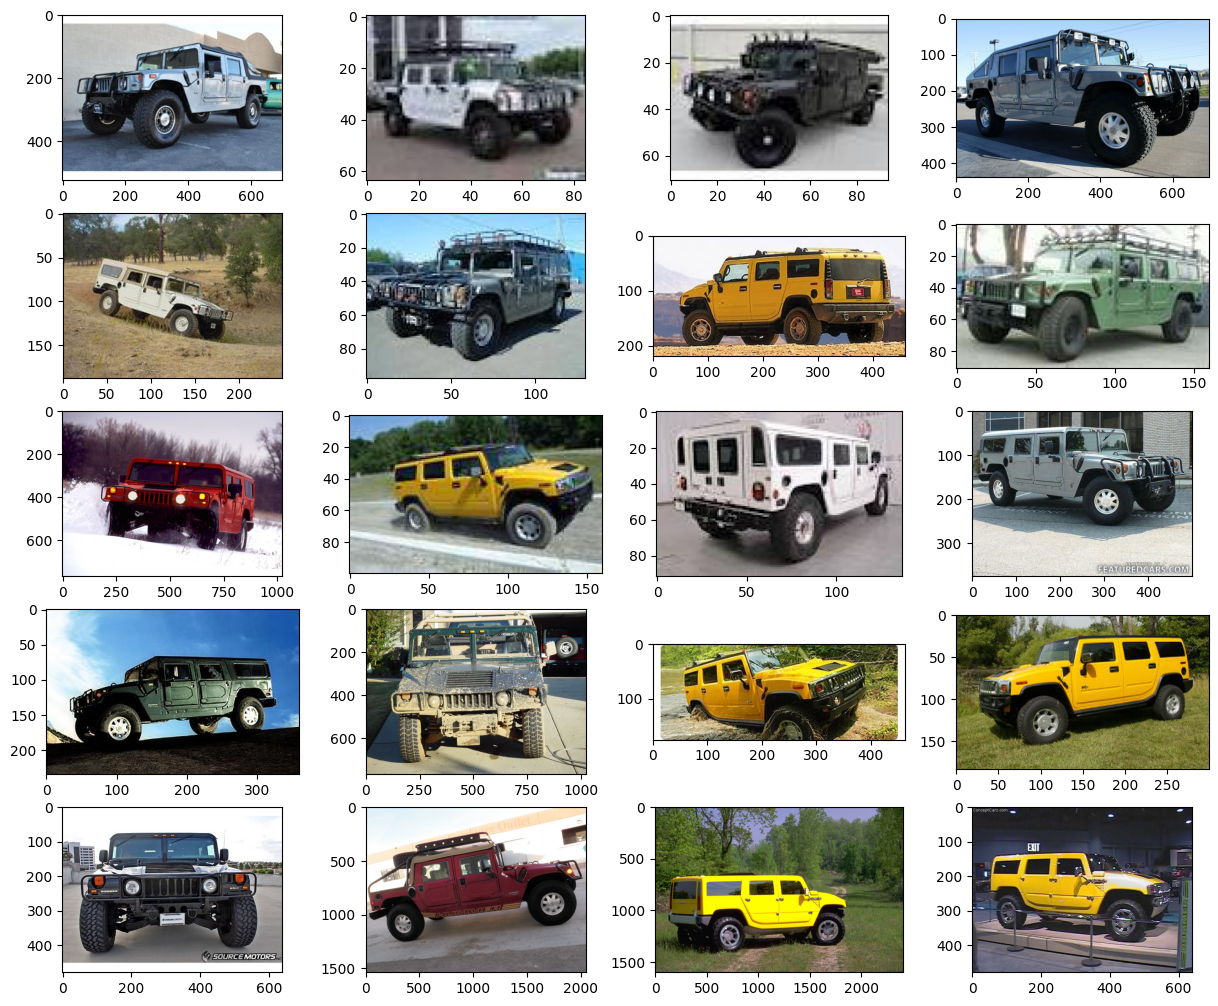

In [26]:
image, label = train_dataset[100]
print('image_shape:', image, 'label:', label)

image, label = train_dataset[1]
print('image_shape:', image, 'label:', label)
show_images(train_dataset)

# Building the diffusion model

# Step1: The forward process = Noise scheduler
We first need to build the inputs for our model, which are more and more noisy images. Instead of doing this sequentially, 
we can use the closed form provided in the papers to calculate the image for any of the timesteps individually.

Key Takeaways:

* The noise-levels/variances can be pre-computed
* There are different types of variance schedules
* We can sample each timestep image independently (Sums of Gaussians is also Gaussian)
* No model is needed in this forward step

# Forward Diffusion Math
* alphas = 1. - betas    :       \\(\alpha_t := 1 - \beta_t\\)
* alphas_cumprod : \\(\bar{\alpha}_t := \Pi_{s=1}^{t} \alpha_s\\)
* alphas_cumprod_prev: \\(\bar{\alpha}_{t-1}\\)
* sqrt_alphas_cumprod: \\(\sqrt{\bar{\alpha}}\\)
* sqrt_alphas_cumprod_t: \\(\sqrt{\bar{\alpha}_{t}}\\)
* sqrt_one_minus_alphas_cumprod: \\(\sqrt{1- \bar{\alpha}}\\)
* sqrt_one_minus_alphas_cumprod_t: \\(\sqrt{1- \bar{\alpha}_t}\\)
* posterior_variance: \\(\beta * (1-\bar{\alpha}) / (1 - \bar{\alpha})\\)
* forward_diffusion_sample
  * mean is: \\(\sqrt{\bar{\alpha}_{t}} * x_0 + \sqrt{1- \bar{\alpha}_t} * noise\\)
  * variance is: noise

In [116]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )

    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

print(sqrt_alphas_cumprod)
print(get_index_from_list(sqrt_alphas_cumprod, torch.tensor([0, 1, 3, 10]), image.shape))
t = torch.tensor([0, 1, 3, 10])
batch_size = t.shape[0]
out = sqrt_alphas_cumprod.gather(-1, t.cpu())
print(batch_size)
print(out)

tensor([0.9999, 0.9999, 0.9998, 0.9996, 0.9994, 0.9992, 0.9990, 0.9987, 0.9984,
        0.9980, 0.9976, 0.9972, 0.9968, 0.9963, 0.9958, 0.9952, 0.9946, 0.9940,
        0.9934, 0.9927, 0.9920, 0.9912, 0.9905, 0.9897, 0.9888, 0.9880, 0.9870,
        0.9861, 0.9851, 0.9841, 0.9831, 0.9820, 0.9809, 0.9798, 0.9787, 0.9775,
        0.9763, 0.9750, 0.9737, 0.9724, 0.9711, 0.9697, 0.9683, 0.9668, 0.9654,
        0.9639, 0.9624, 0.9608, 0.9592, 0.9576, 0.9560, 0.9543, 0.9526, 0.9509,
        0.9491, 0.9473, 0.9455, 0.9437, 0.9418, 0.9399, 0.9380, 0.9360, 0.9340,
        0.9320, 0.9300, 0.9279, 0.9258, 0.9237, 0.9216, 0.9194, 0.9172, 0.9150,
        0.9128, 0.9105, 0.9082, 0.9059, 0.9036, 0.9012, 0.8988, 0.8964, 0.8940,
        0.8915, 0.8890, 0.8865, 0.8840, 0.8815, 0.8789, 0.8763, 0.8737, 0.8711,
        0.8684, 0.8657, 0.8630, 0.8603, 0.8576, 0.8548, 0.8520, 0.8492, 0.8464,
        0.8436, 0.8407, 0.8378, 0.8350, 0.8320, 0.8291, 0.8262, 0.8232, 0.8202,
        0.8172, 0.8142, 0.8112, 0.8082, 

In [117]:
from torchvision import transforms 
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 64
BATCH_SIZE = 128

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1] 
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    ]
    data_transform = transforms.Compose(data_transforms)

    train_dataset = ImageFolder(DATA_DIR_TRAIN, transform = transforms.Compose(data_transforms))
    test_dataset = ImageFolder(DATA_DIR_TEST, transform = transforms.Compose(data_transforms))
    
    train = train_dataset
    test = test_dataset

    return torch.utils.data.ConcatDataset([train, test])
    
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

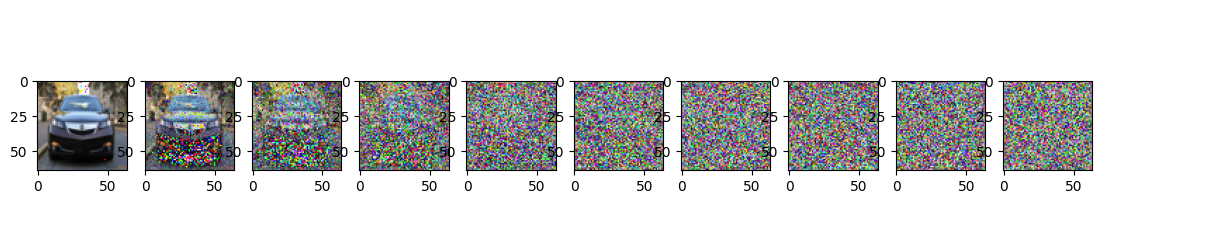

In [118]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,3))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

# Step 2: The backward process = U-Net
For a great introduction to UNets, have a look at this post: https://amaarora.github.io/2020/09/13/unet.html.
Key Takeaways:
* We use a simple form of a UNet for to predict the noise in the image
* The input is a noisy image, the output the noise in the image
* Because the parameters are shared across time, we need to tell the network in which timestep we are
* The timestep is encoded by transformer Sinusoidal Embedding
* We output one single value (mean), because the variance is fixed

In [119]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        
        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor

# Step 3: The loss

Key Takeaways:
* After some maths we end up with a very simple loss function
* There are other possible choices like L2 loss ect.

In [120]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

# Sampling
* Without adding @torch.no_grad() we quickly run out of memory, because pytorch tacks all the previous images for gradient calculation
* Because we pre-calculated the noise variances for the forward pass, we also have to use them when we sequentially perform the backward process

In [121]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,3))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()   

# Train

Epoch 0 | step 000 Loss: 0.1178424283862114 


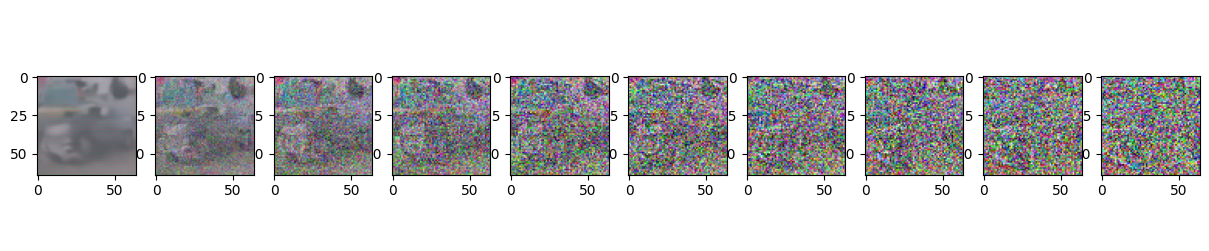

Epoch 5 | step 000 Loss: 0.12712571024894714 


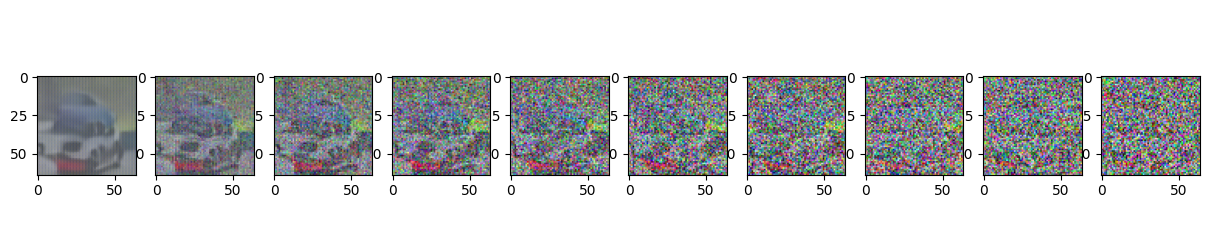

Epoch 10 | step 000 Loss: 0.13598358631134033 


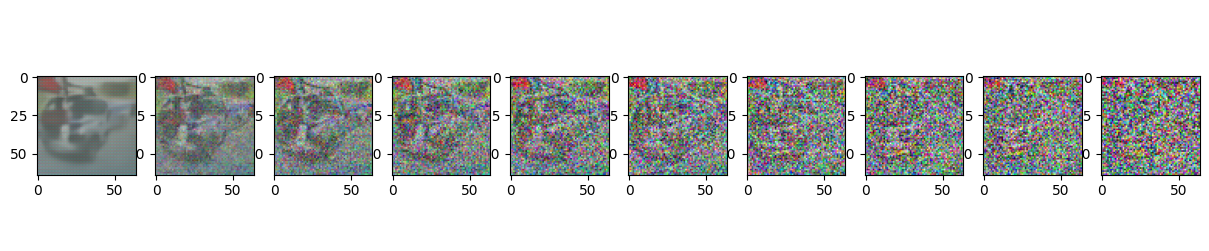

Epoch 15 | step 000 Loss: 0.12023558467626572 


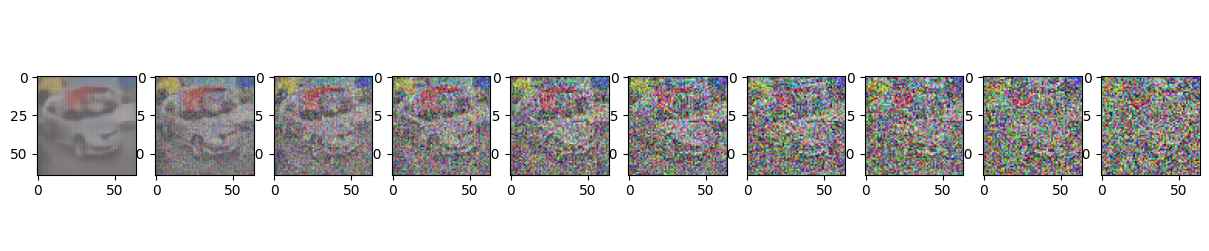

Epoch 20 | step 000 Loss: 0.13676634430885315 


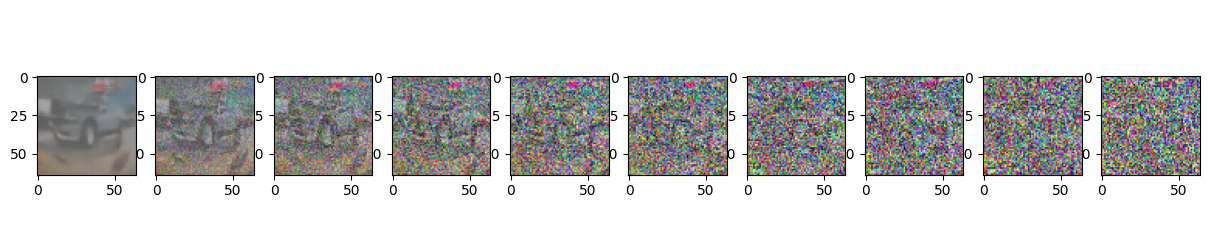

Epoch 25 | step 000 Loss: 0.13258132338523865 


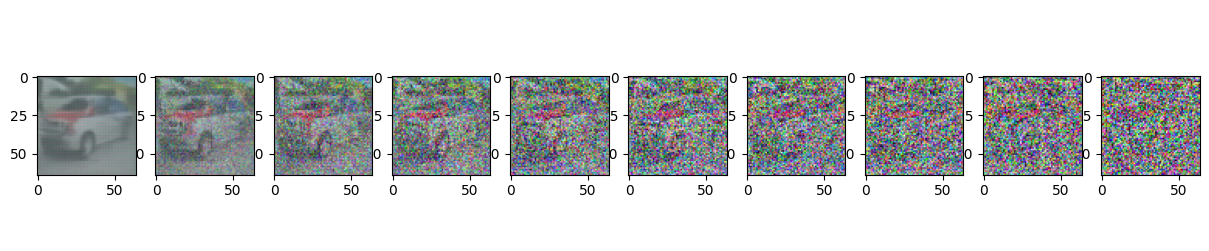

Epoch 30 | step 000 Loss: 0.11872144043445587 


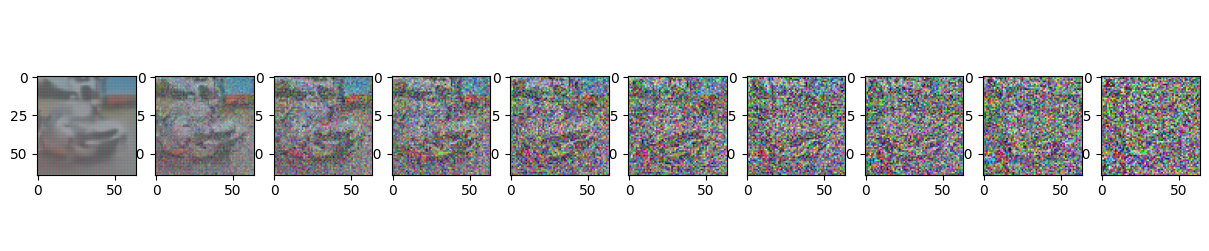

Epoch 35 | step 000 Loss: 0.1327376812696457 


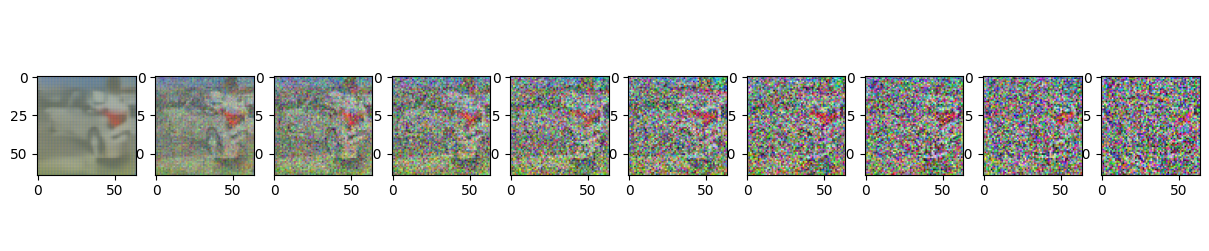

In [ ]:
from torch.optim import Adam
from torch.optim import AdamW

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = AdamW(model.parameters(), lr=0.001)
epochs = 100 # Try more!

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch[0], t)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()

# Inference

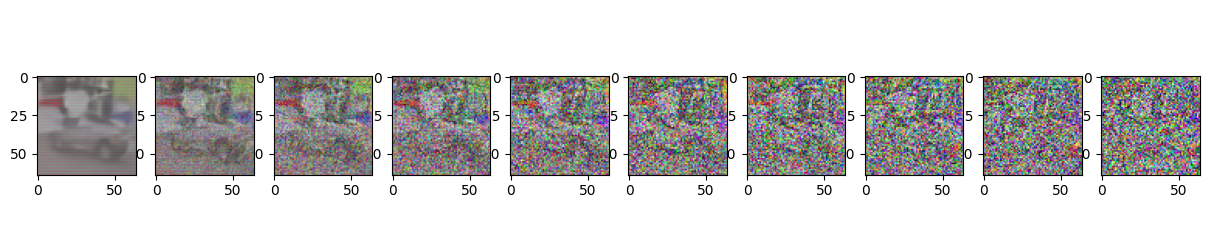

In [144]:
torch.manual_seed(120)
sample_plot_image()

In [143]:
a = torch.tensor([1, 2, 3, 1, 2, 3])
print(a)
b = a[(..., ) + (None, ) * 2]
print(a[(...,) + (None, )])
print(b)
c = a.unsqueeze(0)
print(c)

tensor([1, 2, 3, 1, 2, 3])
tensor([[1],
        [2],
        [3],
        [1],
        [2],
        [3]])
tensor([[[1]],

        [[2]],

        [[3]],

        [[1]],

        [[2]],

        [[3]]])
tensor([[1, 2, 3, 1, 2, 3]])


In [101]:
print(torch.linspace(0,300,301))

tensor([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
         24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
         36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
         48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,
         60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
         72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
         84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,
         96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106., 107.,
        108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119.,
        120., 121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
        132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
        144., 145., 146., 147., 148., 14

In [105]:
torch.linspace(0,300,301).to(torch.int64)

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 1